<a href="https://colab.research.google.com/github/y-ashaswini/notebooks/blob/main/fine_tuning_problem_statement_4_fine_food_analysisipynb_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers datasets torch scikit-learn matplotlib peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
import time

In [28]:
# Load Amazon Fine Food Reviews dataset
review_url = "Reviews.csv"
reviews_df = pd.read_csv(review_url, nrows = 200000)

# Map ratings to binary sentiment (1 for ratings 4-5, 0 for ratings 1-2)
# We will ignore neutral reviews (rating 3) for this binary classification task
reviews_df = reviews_df[reviews_df['Score'] != 3]
reviews_df['label'] = reviews_df['Score'].map({1: 0, 2: 0, 4: 1, 5: 1})

# Only keep necessary columns
reviews_df = reviews_df[['Text', 'label']].dropna()

# Check the size of the dataset
print(f"Dataset size: {len(reviews_df)}")

# Reduce dataset size for quicker training if the dataset is large
if len(reviews_df) > 8000:
    reviews_df = reviews_df.sample(n=8000, random_state=42)

dataset = Dataset.from_pandas(reviews_df)
dataset = dataset.train_test_split(test_size=0.2)
dataset

Dataset size: 184376


DatasetDict({
    train: Dataset({
        features: ['Text', 'label', '__index_level_0__'],
        num_rows: 6400
    })
    test: Dataset({
        features: ['Text', 'label', '__index_level_0__'],
        num_rows: 1600
    })
})

In [29]:
# Define tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Function to tokenize data
def preprocess_function(examples):
    return tokenizer(examples['Text'], truncation=True, padding='max_length', max_length=128)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [30]:
# Metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)  # Convert logits to tensor
    acc = accuracy_score(labels, predictions)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec}

In [35]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=0.2,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [32]:
# Function to train and evaluate model
def train_and_evaluate(model, training_args, tokenized_datasets):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
    )

    start_time = time.time()
    trainer.train()
    train_time = time.time() - start_time

    start_time = time.time()
    eval_results = trainer.evaluate()
    eval_time = time.time() - start_time

    eval_results['train_time'] = train_time
    eval_results['eval_time'] = eval_time

    return eval_results

In [33]:
# Base Model without Soft Prompts or LoRA
base_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)
base_results = train_and_evaluate(base_model, training_args, tokenized_datasets)
print("Base Model Results:", base_results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.195000,0.166016,0.937500,0.962547,0.962547,0.962547


Base Model Results: {'eval_loss': 0.16601550579071045, 'eval_accuracy': 0.9375, 'eval_f1': 0.9625468164794008, 'eval_precision': 0.9625468164794008, 'eval_recall': 0.9625468164794008, 'eval_runtime': 315.5725, 'eval_samples_per_second': 5.07, 'eval_steps_per_second': 0.317, 'epoch': 1.0, 'train_time': 4345.764007806778, 'eval_time': 315.57954025268555}


In [34]:
import torch.nn as nn

class SoftPromptModel(AutoModelForSequenceClassification):
    def __init__(self, config, num_labels, soft_prompt_length=20):
        super().__init__(config)
        self.num_labels = num_labels
        self.soft_prompt_length = soft_prompt_length
        self.soft_prompt_embed = nn.Embedding(self.soft_prompt_length, config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        soft_prompt=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

In [36]:
soft_prompt_model = SoftPromptModel.from_pretrained(model_checkpoint, num_labels=2)
soft_prompt_results = train_and_evaluate(soft_prompt_model, training_args, tokenized_datasets)
print("Soft Prompt Results:", soft_prompt_results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.182300,0.196043,0.920625,0.952806,0.945428,0.960300


Soft Prompt Results: {'eval_loss': 0.19604316353797913, 'eval_accuracy': 0.920625, 'eval_f1': 0.9528056484578223, 'eval_precision': 0.9454277286135693, 'eval_recall': 0.9602996254681648, 'eval_runtime': 318.0581, 'eval_samples_per_second': 5.031, 'eval_steps_per_second': 0.314, 'epoch': 0.5, 'train_time': 2360.0597970485687, 'eval_time': 318.06445479393005}


In [38]:
from peft import get_peft_model, LoraConfig, TaskType

# Define LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification task
    r=8,                        # Low rank
    lora_alpha=32,              # Alpha parameter for LoRA
    lora_dropout=0.1,           # Dropout for LoRA
    bias="none",
    target_modules=["q_lin", "v_lin"]
)

# Apply LoRA to the base model
lora_model = get_peft_model(AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2), lora_config)

# Train and evaluate the LoRA model
lora_results = train_and_evaluate(lora_model, training_args, tokenized_datasets)
print("LoRA Model Results:", lora_results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.445900,0.430813,0.834375,0.909710,0.834375,1.000000


LoRA Model Results: {'eval_loss': 0.43081334233283997, 'eval_accuracy': 0.834375, 'eval_f1': 0.9097103918228279, 'eval_precision': 0.834375, 'eval_recall': 1.0, 'eval_runtime': 325.0684, 'eval_samples_per_second': 4.922, 'eval_steps_per_second': 0.308, 'epoch': 0.5, 'train_time': 1712.3468475341797, 'eval_time': 325.07635021209717}


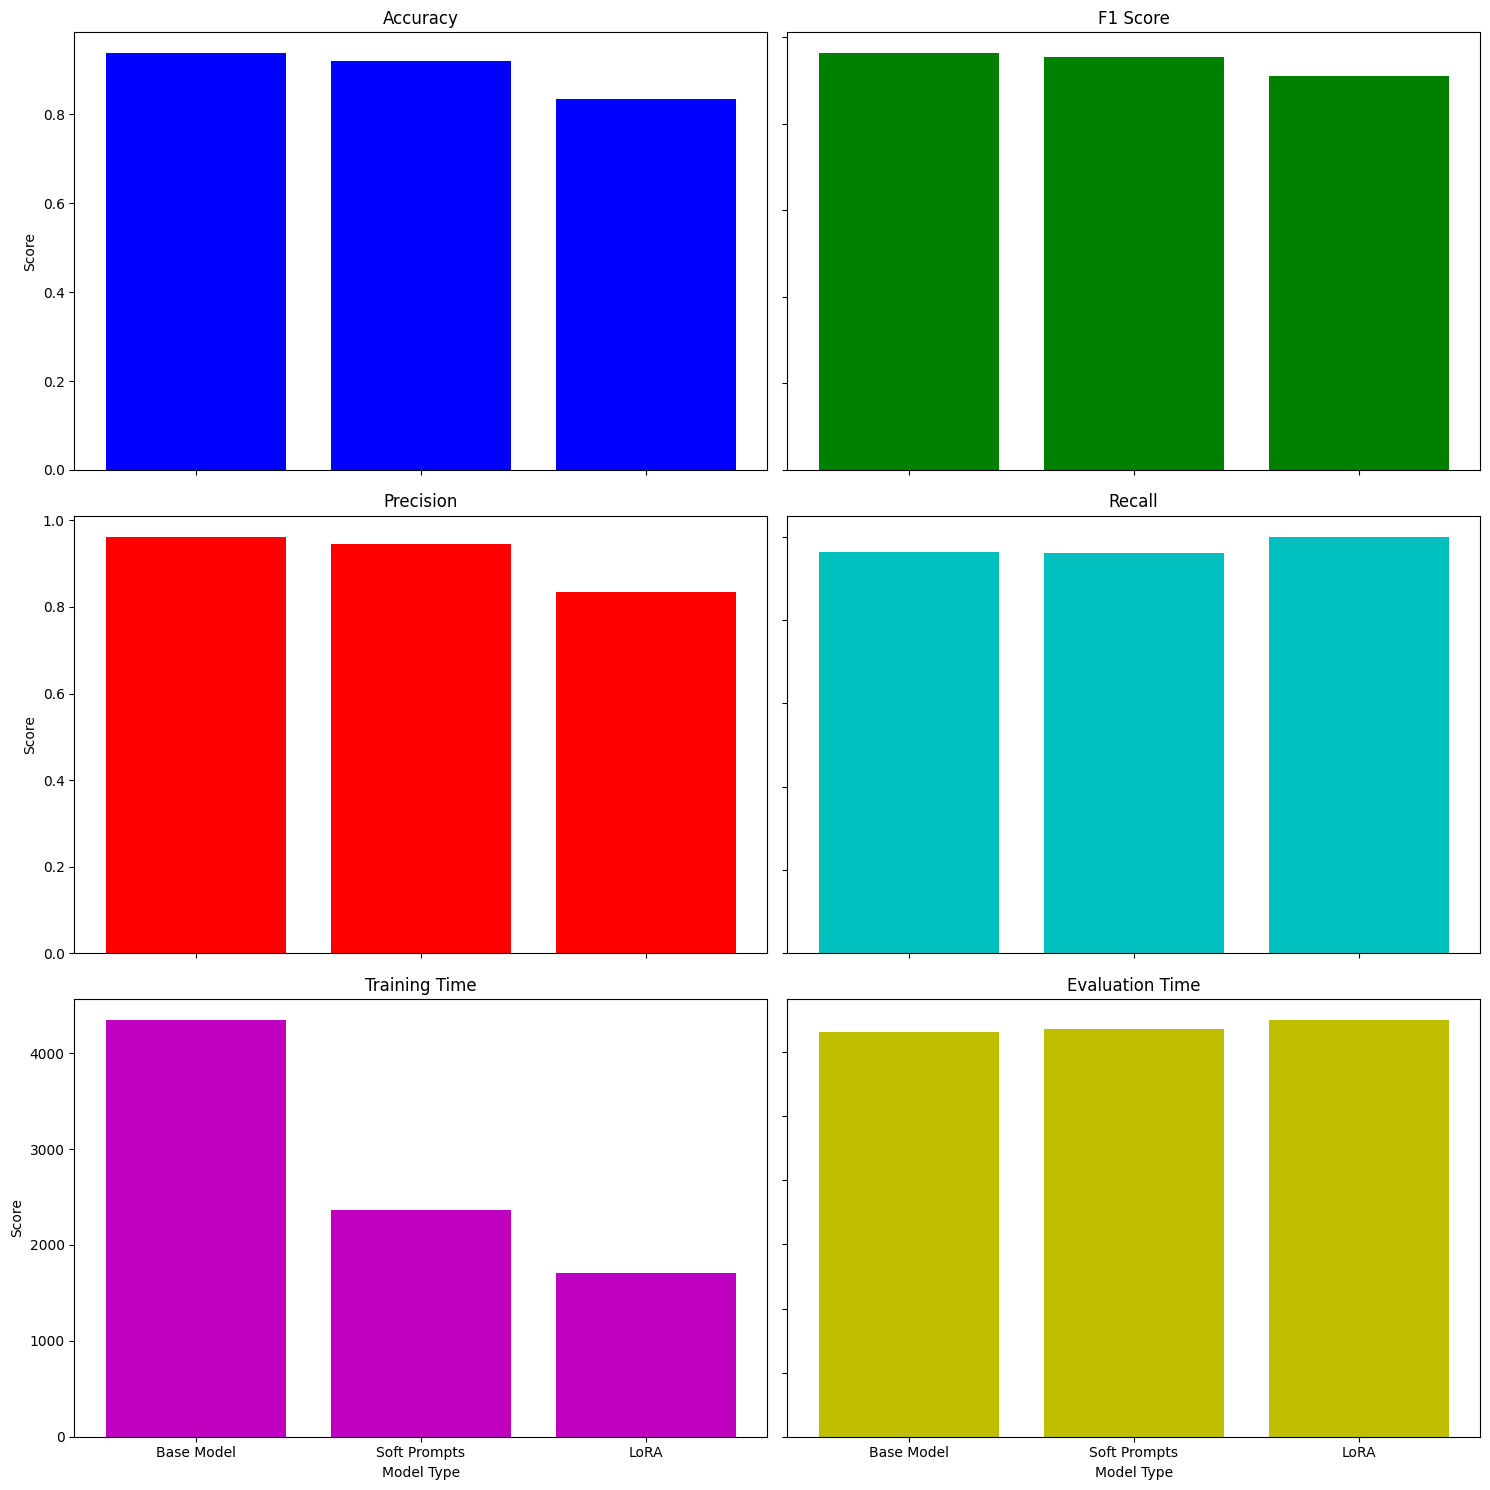

In [39]:
# Visualization
labels = ["Base Model", "Soft Prompts", "LoRA"]
accuracy = [base_results.get("eval_accuracy", 0), soft_prompt_results.get("eval_accuracy", 0), lora_results.get("eval_accuracy", 0)]
f1 = [base_results.get("eval_f1", 0), soft_prompt_results.get("eval_f1", 0), lora_results.get("eval_f1", 0)]
precision = [base_results.get("eval_precision", 0), soft_prompt_results.get("eval_precision", 0), lora_results.get("eval_precision", 0)]
recall = [base_results.get("eval_recall", 0), soft_prompt_results.get("eval_recall", 0), lora_results.get("eval_recall", 0)]
train_time = [base_results.get("train_time", 0), soft_prompt_results.get("train_time", 0), lora_results.get("train_time", 0)]
eval_time = [base_results.get("eval_time", 0), soft_prompt_results.get("eval_time", 0), lora_results.get("eval_time", 0)]

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].bar(labels, accuracy, color='b')
axs[0, 0].set_title('Accuracy')
axs[0, 1].bar(labels, f1, color='g')
axs[0, 1].set_title('F1 Score')
axs[1, 0].bar(labels, precision, color='r')
axs[1, 0].set_title('Precision')
axs[1, 1].bar(labels, recall, color='c')
axs[1, 1].set_title('Recall')
axs[2, 0].bar(labels, train_time, color='m')
axs[2, 0].set_title('Training Time')
axs[2, 1].bar(labels, eval_time, color='y')
axs[2, 1].set_title('Evaluation Time')

for ax in axs.flat:
    ax.set_ylabel('Score')
    ax.set_xlabel('Model Type')
    ax.label_outer()

plt.tight_layout()
plt.show()